In [60]:
import numpy as np

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 

from src.data import load_dataset
from src.models import *

In [46]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
def get_grader_data(model, X_train, y_train):
    predict_train = model.predict(X_train)
    wrong_idx = (predict_train != y_train).astype(int)

    n_wrong = np.count_nonzero(wrong_idx)
    if n_wrong == 0 or n_wrong == X_train.shape[0]:
        return X_train.copy(), wrong_idx
    elif n_wrong == 1:
        os = RandomOverSampler(random_state=0)
        return os.fit_resample(X_train, wrong_idx)
    else:
        k_neighbors = min(n_wrong - 1, 5)
        smote = SMOTE(k_neighbors=k_neighbors, random_state=0)
        return smote.fit_resample(X_train, wrong_idx)

In [48]:
dataset_id = 863
X, y = load_dataset(dataset_id)
le = LabelEncoder()
y = le.fit_transform(y)
y[:5]

array([0, 0, 0, 0, 1])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape

(811, 6)

In [50]:
X_subtrain, X_calibration, y_subtrain, y_calibration = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
X_subtrain.shape

(567, 6)

In [51]:
glass_box = shallow_decision_tree_classifier()
glass_box.fit(X_subtrain, y_subtrain)
glass_box.score(X_train, y_train)

0.7090012330456227

In [52]:
glass_box.score(X_test, y_test)

0.6748768472906403

In [53]:
black_box = OptunaXGBoostClassifier()
black_box.fit(X_subtrain, y_subtrain)
black_box.score(X_train, y_train)

0.8976572133168927

In [54]:
black_box.score(X_test, y_test)

0.7881773399014779

In [55]:
switch_grader_x, switch_grader_y = get_grader_data(glass_box, X_calibration, y_calibration)
switch_grader = shallow_decision_tree_classifier()
switch_grader.fit(switch_grader_x, switch_grader_y)
switch_grader.score(switch_grader_x, switch_grader_y)

0.7155172413793104

In [56]:
reject_grader_x, reject_grader_y = get_grader_data(black_box, X_calibration, y_calibration)
reject_grader = shallow_decision_tree_classifier()
reject_grader.fit(reject_grader_x, reject_grader_y)
reject_grader.score(reject_grader_x, reject_grader_y)

0.7788944723618091

In [57]:
switch_grader

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=19),
             param_grid={'max_depth': [1, 2, 3, 4]})

In [64]:
from sklearn.tree import plot_tree
metadata = fetch_ucirepo(id=863) 
metadata.data.features.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object')

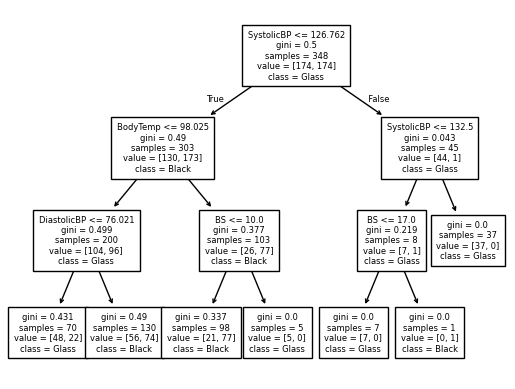

In [67]:
plot_tree(switch_grader.best_estimator_, feature_names=metadata.data.features.columns, class_names=['Glass', 'Black'], fontsize=6);

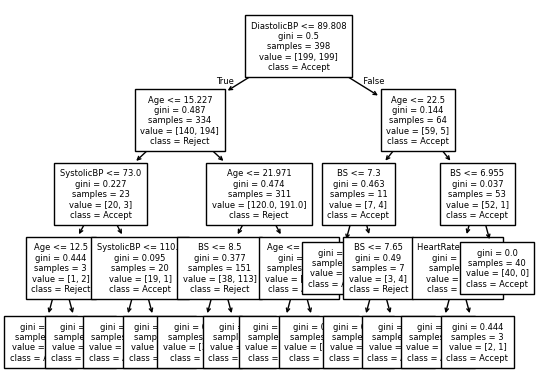

In [68]:
plot_tree(reject_grader.best_estimator_, feature_names=metadata.data.features.columns, class_names=['Accept', 'Reject'], fontsize=6);